In [18]:
from backtesting import Backtest, Strategy
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from backtesting.lib import crossover,plot_heatmaps,resample_apply
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#collecting data from yfinance

data = yf.download(tickers = 'ITC.NS',period = '7d',interval= '1m')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-02 09:15:00+05:30,428.700012,428.700012,426.700012,426.700012,426.700012,0
2024-04-02 09:16:00+05:30,426.850006,427.200012,426.450012,427.200012,427.200012,76478
2024-04-02 09:17:00+05:30,427.049988,427.700012,427.049988,427.649994,427.649994,34740
2024-04-02 09:18:00+05:30,427.649994,427.649994,427.049988,427.100006,427.100006,40024
2024-04-02 09:19:00+05:30,427.049988,427.250000,426.100006,426.200012,426.200012,102324
...,...,...,...,...,...,...
2024-04-10 15:25:00+05:30,436.450012,436.450012,436.200012,436.399994,436.399994,60780
2024-04-10 15:26:00+05:30,436.399994,436.399994,436.100006,436.399994,436.399994,87429
2024-04-10 15:27:00+05:30,436.350006,436.399994,436.100006,436.399994,436.399994,90565


In [21]:
# Creating Strategy

class strategy1(Strategy):

    upper_bound = 70
    lower_bound = 30
    rsi_length = 14

    def init(self):
        self.minute_rsi = self.I(ta.rsi,pd.Series(self.data.Close),self.rsi_length)
        self.minute5_rsi = resample_apply('5T',ta.rsi,self.data.Close,self.rsi_length)
        
    
    def next(self):

        price = self.data.Close[-1]

        if ((crossover(self.minute_rsi,self.upper_bound,)) and (self.minute5_rsi[-1]  >  self.upper_bound)):
            self.position.close()

        if (crossover(self.lower_bound,self.minute_rsi) and (self.minute5_rsi[-1]  <  self.upper_bound)):
            self.buy(sl=0.95*price)


In [22]:
# Creating bt Engine to perform strategy on data
bt = Backtest(data,strategy1,cash=100000)

#running the engine 
stats = bt.run()

stats

Start                     2024-04-02 09:15...
End                       2024-04-10 15:29...
Duration                      8 days 06:14:00
Exposure Time [%]                   88.854962
Equity Final [$]                 10179.400421
Equity Peak [$]                  10182.850281
Return [%]                           1.794004
Buy & Hold Return [%]                2.226388
Return (Ann.) [%]                   92.837748
Volatility (Ann.) [%]               28.382033
Sharpe Ratio                         3.271004
Sortino Ratio                       17.470901
Calmar Ratio                        49.185172
Max. Drawdown [%]                   -1.887515
Avg. Drawdown [%]                   -0.415502
Max. Drawdown Duration        4 days 18:32:00
Avg. Drawdown Duration        0 days 11:34:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       1.531989
Worst Trade [%]                      0.293393
Avg. Trade [%]                    

In [24]:
bt.plot()

C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1397', ...)

In [82]:
stats,heatmap  = bt.optimize(
    upper_bound = range(70,85,2),
    lower_bound = range(10,25,2),
    rsi_length = range(10,20,1),
    maximize = 'Return [%]',
    constraint= lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True,
    #max_tries = 100
)

heatmap



C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 640 configurations.
  output = _optimize_grid()
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['

upper_bound  lower_bound  rsi_length
70           10           10           -0.046003
                          11            0.218503
                          12                 NaN
                          13                 NaN
                          14                 NaN
                                          ...   
84           24           15            1.495000
                          16            0.471497
                          17           -0.287500
                          18           -0.287500
                          19           -0.287500
Name: Return [%], Length: 640, dtype: float64

In [61]:
bt.plot()

C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Ankit\AppData\Roaming\Python\Python310\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p3255', ...)

In [85]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p3423', ...)

In [73]:
heatmap.unstack()

rsi_length                     10        11        12        13        14  \
upper_bound lower_bound                                                     
70          15           0.023001  0.632507  0.874004  0.241497  0.218503   
            20           0.644004  0.414004  0.931504  1.069499  0.414011   
72          15           0.529004  0.874004  0.851010  0.241497  0.241497   
            20           1.253503  0.943001  0.908510  0.368001  0.437006   
74          15           0.529004  0.874004  0.874004  0.241497  0.287500   
            20           1.161511  0.207006  0.207006  0.345000  0.517507   
76          15           0.529004  0.874004  0.920007  0.287500  0.368001   
            20           0.448510  0.184004  0.253008  0.448503  0.598008   
78          15           0.529004  0.977507  0.977507  0.943001  0.943001   
            20           1.000508  0.287507  0.310508  1.126999  0.230000   
80          15           0.632507  1.633008  1.656003  0.943001  0.943001   
            20           1.104011  0.598008  0.023001  0.828001  1.575501   
82          15           1.311003  1.656003  3.001504  0.943001  0.943001   
            20           0.816504  0.000000  1.368503  1.506497  1.575501   
84          15           2.656504  3.151003  3.151003  0.943001  0.943001   
            20           1.219004  1.495000  1.518001  1.655996  1.725000   

rsi_length                     15        16        17        18        19  
upper_bound lower_bound                                                    
70          15           0.241497  0.241497       NaN       NaN       NaN  
            20           0.529004  0.874004  0.862500  0.287500  0.287500  
72          15           0.241497  0.287500       NaN       NaN       NaN  
            20           0.529004  0.920007  0.966003  0.310501  0.368001  
74          15           0.287500  0.368001       NaN       NaN       NaN  
            20           0.632507  1.058008  1.644499  0.943001  0.943001  
76          15           0.943001  0.943001       NaN       NaN       NaN  
            20           1.311003  1.656003  2.311504  0.943001  0.943001  
78          15           0.943001  0.943001       NaN       NaN       NaN  
            20           1.978008  2.760007  2.990000  0.943001  0.943001  
80          15           0.943001  0.943001       NaN       NaN       NaN  
            20           2.656504  3.001504  2.990000  0.943001  0.943001  
82          15           0.943001  0.943001       NaN       NaN       NaN  
            20           2.806003  3.151003  3.139499  1.678997  1.678997  
84          15           0.943001  1.678997       NaN       NaN       NaN  
            20           2.806003  1.552500  0.781999  0.920000  0.920000

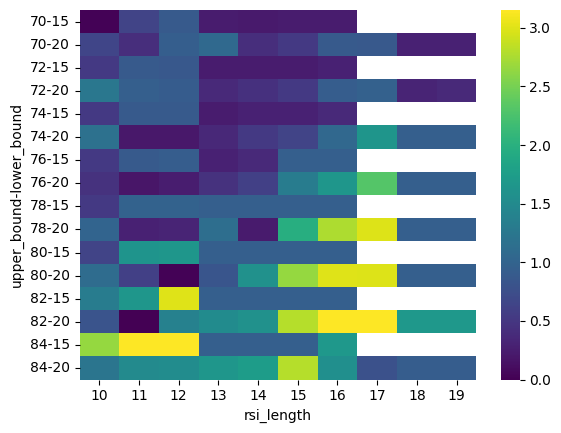

In [81]:
sns.heatmap(heatmap.unstack(),cmap = 'viridis')
plt.show()